## Simulation

We have 5 blocks for our simulation experiment. 
   - Loading packages
   - Defining functions
   - Iteratively simulates
   - Conduct summary statistics 
   - Result visualization

### Block 1

In [1]:
import numpy as np
import pandas as pd
from scipy.special import expit 
from scipy.stats import beta
from statsmodels.api import GLM
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import identity
import matplotlib.pyplot as plt
import seaborn as sns


--- 
### Block 2


In [2]:
# Generate Data
def generate_data_original(n=10000, prob_z4=0.2, prob_z5=0.2, prob_z6=0.2, intrial=True):
    data = pd.DataFrame({
        "Z1": np.random.binomial(1, 0.5, n),
        "Z2": np.random.binomial(1, 0.5, n),
        "Z3": np.random.binomial(1, 0.5, n),
        "Z4": np.random.binomial(1, prob_z4, n),
        "Z5": np.random.binomial(1, prob_z5, n),
        "Z6": np.random.binomial(1, prob_z6, n),
        "X": np.random.binomial(1, 0.5, n),
        "intrial": int(intrial) * np.ones(n)
    })

    data["PY"] = np.clip(
        0.1 + 0.1 * data["X"] + 0.1 * data["Z2"] + 0.1 * data["Z3"] +
        0.1 * data["Z5"] + 0.1 * data["Z6"] +
        0.1 * data["X"] * data["Z3"] + 0.1 * data["X"] * data["Z6"], 0, 1
    )

    data["Y"] = np.random.binomial(1, data["PY"])
    data["intercept"] = 1
    return data



In [3]:
# Functions for OM model with no interaction terms
# Model Fitting
def om_model_fit(study_x0_data, study_x1_data):
    families_identity = Binomial(link=identity())
    predictors = ["Z1", "Z2", "Z3", "Z4", "Z5", "Z6"]

    fitted_models = {}

    fitted_models["model_crude_x0"] = GLM(study_x0_data["Y"], study_x0_data[["intercept"]], family=families_identity).fit()
    fitted_models["model_crude_x1"] = GLM(study_x1_data["Y"], study_x1_data[["intercept"]], family=families_identity).fit()
    
    for predictor in predictors:
        fitted_models[f"model_{predictor}_x0"] = GLM(study_x0_data["Y"], study_x0_data[["intercept", predictor]], family=families_identity).fit()
        fitted_models[f"model_{predictor}_x1"] = GLM(study_x1_data["Y"], study_x1_data[["intercept", predictor]], family=families_identity).fit()
        if predictor != "Z6":
            fitted_models[f"model_{predictor}Z6_x0"] = GLM(study_x0_data["Y"], study_x0_data[["intercept", predictor, "Z6"]], family=families_identity).fit()
            fitted_models[f"model_{predictor}Z6_x1"] = GLM(study_x1_data["Y"], study_x1_data[["intercept", predictor, "Z6"]], family=families_identity).fit()

    return fitted_models


# Model Predicting
def om_model_pred(fitted_models, target_data):
    predicted_data = target_data.copy()

    # Crude models
    predicted_data["crude_x0_pred"] = fitted_models["model_crude_x0"].predict(predicted_data[["intercept"]])
    predicted_data["crude_x1_pred"] = fitted_models["model_crude_x1"].predict(predicted_data[["intercept"]])
    
    predictors = ["Z1", "Z2", "Z3", "Z4", "Z5", "Z6"]
    
    for predictor in predictors: 
        predicted_data[f"{predictor}_x0_pred"] = fitted_models[f"model_{predictor}_x0"].predict(predicted_data[["intercept", predictor]])
        predicted_data[f"{predictor}_x1_pred"] = fitted_models[f"model_{predictor}_x1"].predict(predicted_data[["intercept", predictor]])  
        
        if predictor != "Z6": 
            predicted_data[f"{predictor}Z6_x0_pred"] = fitted_models[f"model_{predictor}Z6_x0"].predict(predicted_data[["intercept", predictor, "Z6"]])
            predicted_data[f"{predictor}Z6_x1_pred"] = fitted_models[f"model_{predictor}Z6_x1"].predict(predicted_data[["intercept", predictor, "Z6"]])
    
    return predicted_data


# Calculating RD
def om_calculate_rd(predicted_data):
    rd_values = {}

    predictors = ["Z1", "Z2", "Z3", "Z4", "Z5", "Z6"]
    
    for predictor in predictors: 
        rd_values[f"rd_{predictor}"] = predicted_data[f"{predictor}_x1_pred"].mean() - predicted_data[f"{predictor}_x0_pred"].mean()
    
    for predictor in predictors:
        if predictor != "Z6":
            rd_values[f"rd_{predictor}Z6"] = predicted_data[f"{predictor}Z6_x1_pred"].mean() - predicted_data[f"{predictor}Z6_x0_pred"].mean()
    
    return rd_values


In [4]:
# Functions for OM model with interation terms

# Model Fitting (with interaction term Z3 and Z6)
def om_model_fit_XZ3Z6(study_x0_data, study_x1_data):
    study_x0_data = study_x0_data.copy()
    study_x1_data = study_x1_data.copy()
    
    study_x0_data["X_Z3"] = study_x0_data["X"] * study_x0_data["Z3"]
    study_x0_data["X_Z6"] = study_x0_data["X"] * study_x0_data["Z6"]
    study_x1_data["X_Z3"] = study_x1_data["X"] * study_x1_data["Z3"]
    study_x1_data["X_Z6"] = study_x1_data["X"] * study_x1_data["Z6"]

    families_identity = Binomial(link=identity())

    predictors = ["Z1", "Z2", "Z4", "Z5"]

    fitted_models = {}

    fitted_models["model_XZ3Z6_intercept_x0"] = GLM(study_x0_data["Y"], study_x0_data[["intercept", "X_Z3", "X_Z6"]], family=families_identity).fit()
    fitted_models["model_XZ3Z6_intercept_x1"] = GLM(study_x1_data["Y"], study_x1_data[["intercept", "X_Z3", "X_Z6"]], family=families_identity).fit()
    
    for predictor in predictors:
        fitted_models[f"model_XZ3Z6_{predictor}_x0"] = GLM(study_x0_data["Y"], study_x0_data[["intercept", predictor, "X_Z3", "X_Z6"]], family=families_identity).fit()
        fitted_models[f"model_XZ3Z6_{predictor}_x1"] = GLM(study_x1_data["Y"], study_x1_data[["intercept", predictor, "X_Z3", "X_Z6"]], family=families_identity).fit()

    return(fitted_models)

    
# Model Fitting (with interaction term Z6 only)
def om_model_fit_XZ6(study_x0_data, study_x1_data):
    
    study_x0_data["X_Z6"] = study_x0_data["X"] * study_x0_data["Z6"]
    study_x1_data["X_Z6"] = study_x1_data["X"] * study_x1_data["Z6"]

    families_identity = Binomial(link=identity())

    predictors = ["Z1", "Z2", "Z3", "Z4", "Z5"]

    fitted_models = {}

    fitted_models["model_XZ6_intercept_x0"] = GLM(study_x0_data["Y"], study_x0_data[["intercept", "X_Z6"]], family=families_identity).fit()
    fitted_models["model_XZ6_intercept_x1"] = GLM(study_x1_data["Y"], study_x1_data[["intercept", "X_Z6"]], family=families_identity).fit()
    
    for predictor in predictors:
        fitted_models[f"model_XZ6_{predictor}_x0"] = GLM(study_x0_data["Y"], study_x0_data[["intercept", predictor, "X_Z6"]], family=families_identity).fit()
        fitted_models[f"model_XZ6_{predictor}_x1"] = GLM(study_x1_data["Y"], study_x1_data[["intercept", predictor, "X_Z6"]], family=families_identity).fit()

    return(fitted_models)


# Model Predicting (with interaction term Z3 and Z6)
def om_model_pred_XZ3Z6(fitted_models, target_data):
    predicted_data = target_data.copy()
    
    # Ensure interaction terms exist in target data
    predicted_data["X_Z3"] = predicted_data["X"] * predicted_data["Z3"]
    predicted_data["X_Z6"] = predicted_data["X"] * predicted_data["Z6"]
 
    # Crude models
    predicted_data["XZ3Z6_intercept_x0_pred"] = fitted_models["model_XZ3Z6_intercept_x0"].predict(predicted_data[["intercept", "X_Z3", "X_Z6"]])
    predicted_data["XZ3Z6_intercept_x1_pred"] = fitted_models["model_XZ3Z6_intercept_x1"].predict(predicted_data[["intercept", "X_Z3", "X_Z6"]])

    predictors = ["Z1", "Z2", "Z4", "Z5"]
    
    for predictor in predictors: 
        predicted_data[f"XZ3Z6_{predictor}_x0_pred"] = fitted_models[f"model_XZ3Z6_{predictor}_x0"].predict(predicted_data[["intercept", predictor, "X_Z3", "X_Z6"]])
        predicted_data[f"XZ3Z6_{predictor}_x1_pred"] = fitted_models[f"model_XZ3Z6_{predictor}_x1"].predict(predicted_data[["intercept", predictor, "X_Z3", "X_Z6"]]) 
        
    return(predicted_data)

# Model Predicting (with interaction term Z6 only)
def om_model_pred_XZ6(fitted_models, target_data):
    predicted_data = target_data.copy()
    
    # Ensure interaction terms exist in target data
    predicted_data["X_Z6"] = predicted_data["X"] * predicted_data["Z6"]
 
    # Crude models
    predicted_data["XZ6_intercept_x0_pred"] = fitted_models["model_XZ6_intercept_x0"].predict(predicted_data[["intercept", "X_Z6"]])
    predicted_data["XZ6_intercept_x1_pred"] = fitted_models["model_XZ6_intercept_x1"].predict(predicted_data[["intercept", "X_Z6"]])

    predictors = ["Z1", "Z2", "Z3", "Z4", "Z5"]
    
    for predictor in predictors: 
        predicted_data[f"XZ6_{predictor}_x0_pred"] = fitted_models[f"model_XZ6_{predictor}_x0"].predict(predicted_data[["intercept", predictor, "X_Z6"]])
        predicted_data[f"XZ6_{predictor}_x1_pred"] = fitted_models[f"model_XZ6_{predictor}_x1"].predict(predicted_data[["intercept", predictor, "X_Z6"]]) 
        
    return(predicted_data)


# Calculate Risk Difference
def om_calculate_rd_XZ3Z6(predicted_data):
    rd_values = {}
    predictors = ["intercept", "Z1", "Z2", "Z4", "Z5"] 
    for predictor in predictors: 
        rd_values[f"rd_{predictor}"] = predicted_data[f"XZ3Z6_{predictor}_x1_pred"].mean() - predicted_data[f"XZ3Z6_{predictor}_x0_pred"].mean()
    return rd_values

def om_calculate_rd_XZ6(predicted_data):
    rd_values = {}
    predictors = ["intercept", "Z1", "Z2", "Z3", "Z4", "Z5"] 
    for predictor in predictors: 
        rd_values[f"rd_{predictor}"] = predicted_data[f"XZ6_{predictor}_x1_pred"].mean() - predicted_data[f"XZ6_{predictor}_x0_pred"].mean()
    return rd_values


---
### Block 3 

In [5]:
# Simulation for outcome modeling when X is random in both the Study and Target population 
om_rd_result_list_r = []
om_XZ3Z6_rd_result_list_r = []
om_XZ6_rd_result_list_r = []
true_rd_list_r = []


for i in range(200):
    study_data_r = generate_data_original(n=10000, prob_z4=0.2, prob_z5=0.2, prob_z6=0.2, intrial=True)
    target_data_r = generate_data_original(n=10000, prob_z4=0.8, prob_z5=0.8, prob_z6=0.8, intrial=False)
    study_x0_data_r = study_data_r[study_data_r["X"] == 0]
    study_x1_data_r = study_data_r[study_data_r["X"] == 1]

    # OM
    om_fitted_models_r = om_model_fit(study_x0_data_r, study_x1_data_r)
    om_predicted_data_r = om_model_pred(om_fitted_models_r, target_data_r)
    om_rd_values_r = om_calculate_rd(om_predicted_data_r)
    om_rd_result_list_r.append(om_rd_values_r)

    om_XZ3Z6_fitted_models_r = om_model_fit_XZ3Z6(study_x0_data_r, study_x1_data_r)
    om_XZ3Z6_predicted_data_r = om_model_pred_XZ3Z6(om_XZ3Z6_fitted_models_r, target_data_r)
    om_XZ3Z6_rd_values_r = om_calculate_rd_XZ3Z6(om_XZ3Z6_predicted_data_r)
    om_XZ3Z6_rd_result_list_r.append(om_XZ3Z6_rd_values_r)

    om_XZ6_fitted_models_r = om_model_fit_XZ6(study_x0_data_r, study_x1_data_r)
    om_XZ6_predicted_data_r = om_model_pred_XZ6(om_XZ6_fitted_models_r, target_data_r)
    om_XZ6_rd_values_r = om_calculate_rd_XZ6(om_XZ6_predicted_data_r)
    om_XZ6_rd_result_list_r.append(om_XZ6_rd_values_r)
    
    # True result
    true_rd_r = target_data_r.groupby("X")["PY"].mean().diff().iloc[-1]
    true_rd_list_r.append(true_rd_r)



# Combine Results
om_rd_combined_r = pd.DataFrame(om_rd_result_list_r)
om_rd_combined_r["true_rd"] = true_rd_list_r
om_XZ3Z6_rd_combined_r = pd.DataFrame(om_XZ3Z6_rd_result_list_r)
om_XZ3Z6_rd_combined_r["true_rd"] = true_rd_list_r
om_XZ6_rd_combined_r = pd.DataFrame(om_XZ6_rd_result_list_r)
om_XZ6_rd_combined_r["true_rd"] = true_rd_list_r


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The identity link function does not respect the domain of the Binomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The identity link function does not respect the domain of the Binomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The identity link function does not respect the domain of the Binomial family.
  warnings.warn((f"The {type(family.link).__name__

---
### Block 4

In [6]:
# Summary Statistics
om_summary_stats_r = om_rd_combined_r.agg(["mean", "std"]).T
om_summary_stats_r["mse"] = ((om_rd_combined_r.sub(om_rd_combined_r["true_rd"], axis=0))**2).mean()
om_XZ3Z6_summary_stats_r = om_XZ3Z6_rd_combined_r.agg(["mean", "std"]).T
om_XZ3Z6_summary_stats_r["mse"] = ((om_XZ3Z6_rd_combined_r.sub(om_XZ3Z6_rd_combined_r["true_rd"], axis=0))**2).mean()
om_XZ6_summary_stats_r = om_XZ6_rd_combined_r.agg(["mean", "std"]).T
om_XZ6_summary_stats_r["mse"] = ((om_XZ6_rd_combined_r.sub(om_XZ6_rd_combined_r["true_rd"], axis=0))**2).mean()




---
### Block 5

In [7]:
# Function to style the table
def style_table_without_model_column(df, title):
    # Gradient for the `mse` column (blue, dark for smallest)
    mse_colors = (
        df["mse"]
        .rank(method="min", ascending=True, na_option="bottom")
        .apply(lambda x: f"background-color: rgba(0, 0, 255, {0.4 - 0.3 * (x / df['mse'].rank(method='min', na_option='bottom').max())})" if pd.notna(x) else "")
    )
    
    # Gradient for the `std` column (purple, dark for smallest)
    std_colors = (
        df["std"]
        .rank(method="min", ascending=True, na_option="bottom")
        .apply(lambda x: f"background-color: rgba(128, 0, 128, {0.4 - 0.3 * (x / df['std'].rank(method='min', na_option='bottom').max())})" if pd.notna(x) else "")
    )
    
    # Bold the last row (assumed to be `true_rd`, last in the DataFrame)
    def bold_last_row(row):
        return ["font-weight: bold"] * len(row) if row.name == df.index[-1] else [""] * len(row)
    
    # Apply styles
    return (
        df.style
        .apply(lambda _: mse_colors, subset=["mse"])
        .apply(lambda _: std_colors, subset=["std"])
        .apply(bold_last_row, axis=1)  # Bold the last row
        .set_caption(f"<b>{title}</b>")  # Set table title
    )

# Apply the styles
om_styled_summary_df_r = style_table_without_model_column(om_summary_stats_r, "Result when X Random, with no Interaction Term")
om_XZ3Z6_styled_summary_df_r = style_table_without_model_column(om_XZ3Z6_summary_stats_r, "Result when X Random, with Z3 and Z6 Interaction terms")
om_XZ6_styled_summary_df_r = style_table_without_model_column(om_XZ6_summary_stats_r, "Result when X Random, with Z6 Interaction term")


In [8]:
# Display Results
om_styled_summary_df_r


,mean,std,mse
rd_Z1,0.170398,0.009057,0.003669
rd_Z2,0.170306,0.009047,0.003680
rd_Z3,0.170405,0.008810,0.003663
rd_Z4,0.172604,0.016574,0.003597
rd_Z5,0.171432,0.018140,0.003798
rd_Z6,0.231342,0.016963,0.000300
rd_Z1Z6,0.231334,0.016986,0.000300
rd_Z2Z6,0.231398,0.016916,0.000299
rd_Z3Z6,0.231468,0.016540,0.000286
rd_Z4Z6,0.233271,0.021517,0.000478


In [9]:
om_XZ6_styled_summary_df_r

,mean,std,mse
rd_intercept,0.210874,0.009762,0.000478
rd_Z1,0.210882,0.009783,0.000478
rd_Z2,0.210862,0.009803,0.000479
rd_Z3,0.210911,0.009442,0.000469
rd_Z4,0.212926,0.016826,0.000584
rd_Z5,0.211888,0.018690,0.000698
true_rd,0.230207,0.002336,0.000000


In [10]:
om_XZ3Z6_styled_summary_df_r

,mean,std,mse
rd_intercept,0.160707,0.010325,0.004945
rd_Z1,0.160723,0.010345,0.004943
rd_Z2,0.160684,0.010272,0.004947
rd_Z4,0.162973,0.016898,0.004810
rd_Z5,0.161680,0.019195,0.005078
true_rd,0.230207,0.002336,0.000000


/var/folders/74/4fh__5010_l3tp8fpsft2ft00000gn/T/ipykernel_1535/3471558685.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Model", y="RD Estimate", data=df_r_long, ax=axes[0], palette="Set2", showfliers=False)
/var/folders/74/4fh__5010_l3tp8fpsft2ft00000gn/T/ipykernel_1535/3471558685.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=15)
/var/folders/74/4fh__5010_l3tp8fpsft2ft00000gn/T/ipykernel_1535/3471558685.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Model", y="RD Estimate", data=df_r_long, ax=axes[1], palette="Set2", show

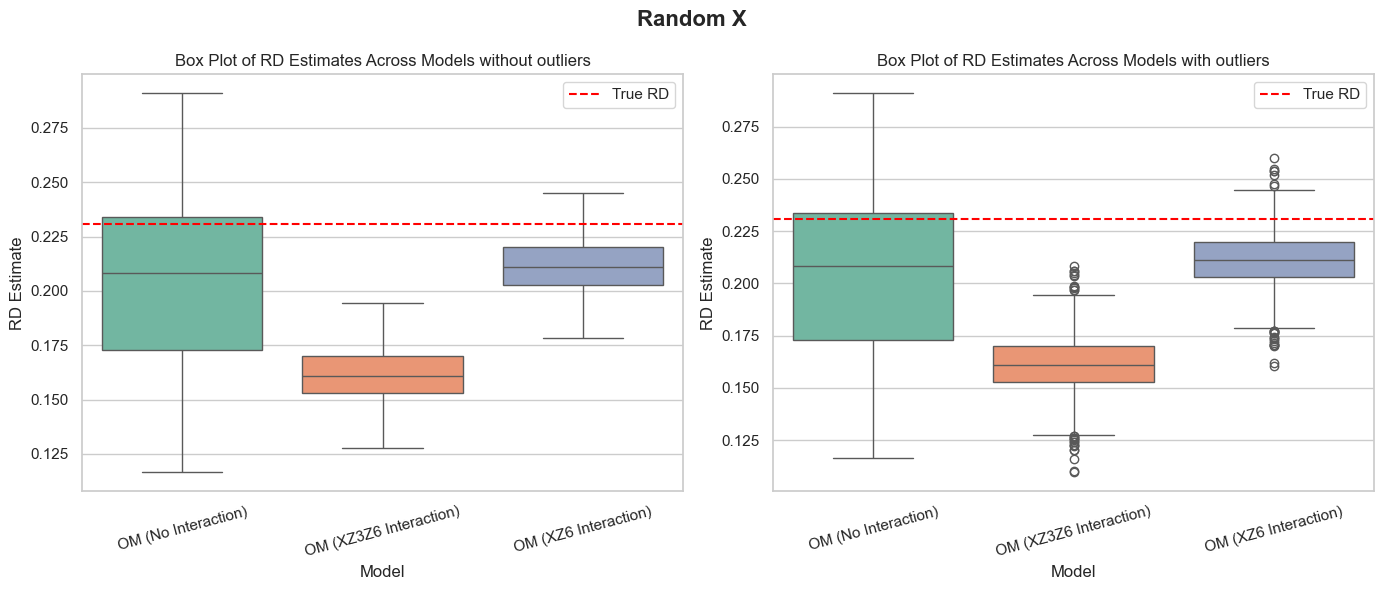

In [11]:
# Box plot: random X

# Assign model names
om_rd_combined_r["Model"] = "OM (No Interaction)"
om_XZ3Z6_rd_combined_r["Model"] = "OM (XZ3Z6 Interaction)"
om_XZ6_rd_combined_r["Model"] = "OM (XZ6 Interaction)"

# Concatenate all data into one DataFrame
df_r = pd.concat([om_rd_combined_r, om_XZ3Z6_rd_combined_r, om_XZ6_rd_combined_r])

# Melt into long format for Seaborn
df_r_long = df_r.melt(id_vars=["Model", "true_rd"], var_name="RD Type", value_name="RD Estimate")

# Extract true RD value
true_rd_value_r = df_r["true_rd"].iloc[0]  

# Set Seaborn style
sns.set(style="whitegrid")

### PLOTTING ###
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Random X", fontsize=16, fontweight='bold')


## BOX PLOT (Hide Outliers) ##
sns.boxplot(x="Model", y="RD Estimate", data=df_r_long, ax=axes[0], palette="Set2", showfliers=False)
axes[0].axhline(y=true_rd_value_r, color="red", linestyle="--", label="True RD")
axes[0].set_title("Box Plot of RD Estimates Across Models without outliers")
axes[0].legend()
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=15)

## (Zoomed In) ##
sns.boxplot(x="Model", y="RD Estimate", data=df_r_long, ax=axes[1], palette="Set2", showfliers=True)
axes[1].axhline(y=true_rd_value_r, color="red", linestyle="--", label="True RD")
axes[1].set_title("Box Plot of RD Estimates Across Models with outliers")
axes[1].legend()
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=15)

# Set a reasonable y-axis limit to remove extreme outliers
#axes[0].set_ylim(true_rd_value - 100.0, true_rd_value + 100)
#axes[1].set_ylim(true_rd_value - 200.0, true_rd_value + 200)

# Adjust layout
plt.tight_layout()
plt.show()



